# Import and EDA

In [50]:
#Dataframe
import pandas as pd
from datetime import datetime as dt
import numpy as np

#Visualizations
import matplotlib.pyplot as plt
import seaborn as sns


#Modeling
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [2]:
df=pd.read_csv('Data\Supply_Chain_Shipment_Pricing_Data.csv')

In [3]:
df.head()

,id,project code,pq #,po / so #,asn/dn #,country,managed by,fulfill via,vendor inco term,shipment mode,...,unit of measure (per pack),line item quantity,line item value,pack price,unit price,manufacturing site,first line designation,weight (kilograms),freight cost (usd),line item insurance (usd)
0,1,100-CI-T01,Pre-PQ Process,SCMS-4,ASN-8,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,...,30,19,551.0,29.00,0.97,Ranbaxy Fine Chemicals LTD,True,13,780.34,NaN
1,3,108-VN-T01,Pre-PQ Process,SCMS-13,ASN-85,Vietnam,PMO - US,Direct Drop,EXW,Air,...,240,1000,6200.0,6.20,0.03,"Aurobindo Unit III, India",True,358,4521.5,NaN
2,4,100-CI-T01,Pre-PQ Process,SCMS-20,ASN-14,Côte d'Ivoire,PMO - US,Direct Drop,FCA,Air,...,100,500,40000.0,80.00,0.80,ABBVIE GmbH & Co.KG Wiesbaden,True,171,1653.78,NaN
3,15,108-VN-T01,Pre-PQ Process,SCMS-78,ASN-50,Vietnam,PMO - US,Direct Drop,EXW,Air,...,60,31920,127360.8,3.99,0.07,"Ranbaxy, Paonta Shahib, India",True,1855,16007.06,NaN
4,16,108-VN-T01,Pre-PQ Process,SCMS-81,ASN-55,Vietnam,PMO - US,Direct Drop,EXW,Air,...,60,38000,121600.0,3.20,0.05,"Aurobindo Unit III, India",True,7590,45450.08,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10324 entries, 0 to 10323
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            10324 non-null  int64  
 1   project code                  10324 non-null  object 
 2   pq #                          10324 non-null  object 
 3   po / so #                     10324 non-null  object 
 4   asn/dn #                      10324 non-null  object 
 5   country                       10324 non-null  object 
 6   managed by                    10324 non-null  object 
 7   fulfill via                   10324 non-null  object 
 8   vendor inco term              10324 non-null  object 
 9   shipment mode                 9964 non-null   object 
 10  pq first sent to client date  10324 non-null  object 
 11  po sent to vendor date        10324 non-null  object 
 12  scheduled delivery date       10324 non-null  object 
 13  d

In [5]:
df['country'].value_counts()

South Africa          1406
Nigeria               1194
Côte d'Ivoire         1083
Uganda                 779
Vietnam                688
Zambia                 683
Haiti                  655
Mozambique             631
Zimbabwe               538
Tanzania               519
Rwanda                 430
Congo, DRC             333
Guyana                 237
Ethiopia               216
South Sudan            164
Kenya                  111
Burundi                 98
Namibia                 95
Cameroon                75
Botswana                70
Ghana                   58
Dominican Republic      52
Sudan                   46
Swaziland               35
Mali                    17
Pakistan                15
Guatemala               15
Malawi                  14
Benin                   13
Libya                    8
Lebanon                  8
Angola                   7
Liberia                  6
Sierra Leone             4
Lesotho                  4
Afghanistan              3
Togo                     3
S

In [6]:
df['shipment mode'].value_counts()

Air            6113
Truck          2830
Air Charter     650
Ocean           371
Name: shipment mode, dtype: int64

# Data Cleaning

### Dropping Columns

In [7]:
df.drop(columns=[
    'pq #',
    'po / so #',
    'asn/dn #', 
    'pq first sent to client date', 
    'po sent to vendor date', 
    'line item insurance (usd)', 
    'id',
    'project code',
    'managed by',
    'fulfill via',
    'vendor inco term',
    'shipment mode',
    'delivery recorded date',
    'molecule/test type',
    'brand',
    'dosage',
    'dosage form',
    'unit of measure (per pack)',
    'pack price',
    'unit price',
    'manufacturing site',
    'first line designation',
    'weight (kilograms)',
    'freight cost (usd)'], inplace=True)

## Dropping Rows

Dropping countries with less than 100 instances--As most of the countries left are in Africa, dropping countries outside of African continent

In [8]:
df = df[df['country'].map(df['country'].value_counts()) >= 100]
df.drop(df[df['country'] == 'Haiti'].index, inplace=True)
df.drop(df[df['country'] == 'Vietnam'].index, inplace=True)
df.drop(df[df['country'] == 'Guyana'].index, inplace=True)

In [9]:
df['country'].value_counts() #SANITY CHECK

South Africa     1406
Nigeria          1194
Côte d'Ivoire    1083
Uganda            779
Zambia            683
Mozambique        631
Zimbabwe          538
Tanzania          519
Rwanda            430
Congo, DRC        333
Ethiopia          216
South Sudan       164
Kenya             111
Name: country, dtype: int64

In [10]:
#Grouping countries together based on their location on the continent 
region_map = {
    'South Africa': 'south',
    'Nigeria': 'west',
    "Côte d'Ivoire": 'west',
    'Uganda': 'east',
    'Zambia': 'south',
    'Mozambique': 'south',
    'Zimbabwe': 'south',
    'Tanzania': 'east',
    'Rwanda': 'east',
    'Congo, DRC': 'east',#Congo is Central but groiuping with east
    'Ethiopia': 'east',
    'South Sudan': 'north',
    'Kenya': 'east'
}

df[['east', 'west', 'south', 'north']] = df['country'].apply(lambda x: pd.Series({
    'east': 1 if region_map[x] == 'east' else 0,
    'west': 1 if region_map[x] == 'west' else 0,
    'south': 1 if region_map[x] == 'south' else 0,
    'north': 1 if region_map[x] == 'north' else 0
}))

In [11]:
df.info() #SANITY CHECK

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8087 entries, 0 to 10323
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   country                   8087 non-null   object 
 1   scheduled delivery date   8087 non-null   object 
 2   delivered to client date  8087 non-null   object 
 3   product group             8087 non-null   object 
 4   sub classification        8087 non-null   object 
 5   vendor                    8087 non-null   object 
 6   item description          8087 non-null   object 
 7   line item quantity        8087 non-null   int64  
 8   line item value           8087 non-null   float64
 9   east                      8087 non-null   int64  
 10  west                      8087 non-null   int64  
 11  south                     8087 non-null   int64  
 12  north                     8087 non-null   int64  
dtypes: float64(1), int64(5), object(7)
memory usage: 884.5+ KB


In [12]:
df.head()#per capita or more need 

,country,scheduled delivery date,delivered to client date,product group,sub classification,vendor,item description,line item quantity,line item value,east,west,south,north
0,Côte d'Ivoire,2-Jun-06,2-Jun-06,HRDT,HIV test,RANBAXY Fine Chemicals LTD.,"HIV, Reveal G3 Rapid HIV-1 Antibody Test, 30 T...",19,551.00,0,1,0,0
2,Côte d'Ivoire,27-Aug-06,27-Aug-06,HRDT,HIV test,Abbott GmbH & Co. KG,"HIV 1/2, Determine Complete HIV Kit, 100 Tests",500,40000.00,0,1,0,0
5,Nigeria,28-Sep-06,28-Sep-06,ARV,Pediatric,Aurobindo Pharma Limited,"Zidovudine 10mg/ml, oral solution, Bottle, 240 ml",416,2225.60,0,1,0,0
6,Zambia,8-Jan-07,8-Jan-07,ARV,Pediatric,MERCK SHARP & DOHME IDEA GMBH (FORMALLY MERCK ...,"Efavirenz 200mg [Stocrin/Sustiva], capsule, 90...",135,4374.00,0,0,1,0
7,Tanzania,24-Nov-06,24-Nov-06,ARV,Adult,Aurobindo Pharma Limited,"Nevirapine 200mg, tablets, 60 Tabs",16667,60834.55,1,0,0,0


In [13]:
df['vendor'].value_counts()

SCMS from RDC                                                        4709
S. BUYS WHOLESALER                                                    715
Orgenics, Ltd                                                         564
Aurobindo Pharma Limited                                              398
PHARMACY DIRECT                                                       326
Trinity Biotech, Plc                                                  241
ABBVIE LOGISTICS (FORMERLY ABBOTT LOGISTICS BV)                       196
CIPLA LIMITED                                                         113
MYLAN LABORATORIES LTD (FORMERLY MATRIX LABORATORIES)                  94
CHEMBIO DIAGNOSTIC SYSTEMS, INC.                                       86
Standard Diagnostics, Inc.                                             79
HETERO LABS LIMITED                                                    68
MERCK SHARP & DOHME IDEA GMBH (FORMALLY MERCK SHARP & DOHME B.V.)      53
SHANGHAI KEHUA BIOENGINEERING CO.,LTD.

In [14]:
#Dropping vendors with less than 50 instances
df = df[df['vendor'].map(df['vendor'].value_counts()) >= 50]

In [15]:
#Checking the rows where the two date columns don't match
df['unscheduled_delivery'] = df.apply(lambda row: row['scheduled delivery date'] != row['delivered to client date'], axis=1)
df[df['unscheduled_delivery'] == True]

,country,scheduled delivery date,delivered to client date,product group,sub classification,vendor,item description,line item quantity,line item value,east,west,south,north,unscheduled_delivery
51,South Africa,25-Apr-08,7-Apr-08,ARV,Pediatric,S. BUYS WHOLESALER,"Didanosine 25mg [Videx], chewable tablets, 60 ...",6,77.10,0,0,1,0,True
53,Nigeria,9-Jul-08,4-Jul-08,HRDT,HIV test - Ancillary,"Orgenics, Ltd","HIV, Lancet, Safety, for HIV Test kits, 100 Pcs",5498,54.98,0,1,0,0,True
57,South Africa,20-Aug-08,8-May-08,ARV,Adult,S. BUYS WHOLESALER,"Didanosine EC 250mg [Videx EC], delayed-releas...",100,1906.00,0,0,1,0,True
58,South Africa,20-Aug-08,8-May-08,ARV,Pediatric,S. BUYS WHOLESALER,"Stavudine 1mg/ml [Zerit], powder for oral solu...",670,1025.10,0,0,1,0,True
62,South Africa,12-Jun-08,9-Jun-08,ARV,Adult,S. BUYS WHOLESALER,"Abacavir 300mg [Ziagen], tablets, Blister 6 x ...",30,1049.40,0,0,1,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10319,Zimbabwe,31-Jul-15,15-Jul-15,ARV,Pediatric,SCMS from RDC,"Lamivudine/Nevirapine/Zidovudine 30/50/60mg, d...",166571,599655.60,0,0,1,0,True
10320,Côte d'Ivoire,31-Jul-15,6-Aug-15,ARV,Adult,SCMS from RDC,"Lamivudine/Zidovudine 150/300mg, tablets, 60 Tabs",21072,137389.44,0,1,0,0,True
10321,Zambia,31-Aug-15,25-Aug-15,ARV,Adult,SCMS from RDC,Efavirenz/Lamivudine/Tenofovir Disoproxil Fuma...,514526,5140114.74,0,0,1,0,True
10322,Zimbabwe,9-Sep-15,4-Aug-15,ARV,Adult,SCMS from RDC,"Lamivudine/Zidovudine 150/300mg, tablets, 60 Tabs",17465,113871.80,0,0,1,0,True


In [16]:
#Flagging vendors with the most delayed deliveries 
df[df['unscheduled_delivery'] == True]['vendor'].value_counts()

SCMS from RDC                                                        2874
S. BUYS WHOLESALER                                                    251
Orgenics, Ltd                                                         148
Aurobindo Pharma Limited                                              109
CIPLA LIMITED                                                          28
CHEMBIO DIAGNOSTIC SYSTEMS, INC.                                       12
SHANGHAI KEHUA BIOENGINEERING CO.,LTD.  (KHB)                          10
Standard Diagnostics, Inc.                                             10
ABBVIE LOGISTICS (FORMERLY ABBOTT LOGISTICS BV)                         5
MERCK SHARP & DOHME IDEA GMBH (FORMALLY MERCK SHARP & DOHME B.V.)       2
Trinity Biotech, Plc                                                    1
Name: vendor, dtype: int64

# TimeSeries

In [17]:
df['delivered to client date'] = df['delivered to client date'].astype(str)

In [18]:
df['delivered to client date'] = pd.to_datetime(df['delivered to client date'], infer_datetime_format=True)
df.set_index('delivered to client date', inplace=True)

In [19]:
df.head()#SANITY CHECK

,country,scheduled delivery date,product group,sub classification,vendor,item description,line item quantity,line item value,east,west,south,north,unscheduled_delivery
delivered to client date,,,,,,,,,,,,,
2006-09-28,Nigeria,28-Sep-06,ARV,Pediatric,Aurobindo Pharma Limited,"Zidovudine 10mg/ml, oral solution, Bottle, 240 ml",416,2225.60,0,1,0,0,False
2007-01-08,Zambia,8-Jan-07,ARV,Pediatric,MERCK SHARP & DOHME IDEA GMBH (FORMALLY MERCK ...,"Efavirenz 200mg [Stocrin/Sustiva], capsule, 90...",135,4374.00,0,0,1,0,False
2006-11-24,Tanzania,24-Nov-06,ARV,Adult,Aurobindo Pharma Limited,"Nevirapine 200mg, tablets, 60 Tabs",16667,60834.55,1,0,0,0,False
2006-12-07,Nigeria,7-Dec-06,ARV,Adult,Aurobindo Pharma Limited,"Stavudine 30mg, capsules, 60 Caps",273,532.35,0,1,0,0,False
2007-01-30,Zambia,30-Jan-07,ARV,Adult,ABBVIE LOGISTICS (FORMERLY ABBOTT LOGISTICS BV),"Lopinavir/Ritonavir 200/50mg [Aluvia], tablets...",2800,115080.00,0,0,1,0,False


In [20]:
df.isnull().sum()

country                    0
scheduled delivery date    0
product group              0
sub classification         0
vendor                     0
item description           0
line item quantity         0
line item value            0
east                       0
west                       0
south                      0
north                      0
unscheduled_delivery       0
dtype: int64

### Picking a column to use with date

In [21]:
df['sub classification'].value_counts()

Adult                   5143
Pediatric               1403
HIV test                1045
HIV test - Ancillary     103
Name: sub classification, dtype: int64

In [22]:
df['item description'].value_counts()

Efavirenz 600mg, tablets, 30 Tabs                                                  621
Nevirapine 200mg, tablets, 60 Tabs                                                 517
Lamivudine/Nevirapine/Zidovudine 150/200/300mg, tablets, 60 Tabs                   478
Lamivudine/Zidovudine 150/300mg, tablets, 60 Tabs                                  476
HIV 1/2, Determine Complete HIV Kit, 100 Tests                                     434
                                                                                  ... 
HIV, Pepti-LAV 1|2 (HIV-1|2 Ab differenciation, Immuno-Blot)                         1
Nevirapine 50mg, dispersible tablets, 60 Tabs                                        1
Lamivudine/Nevirapine/Zidovudine 30/50/60mg, [DON] dispersible tablets, 60 Tabs      1
Lamivudine/Zidovudine+Abacavir 150/300+300mg, tablets, co-blister, 60+60 Tabs        1
Ritonavir 100mg [Norvir], film coated tablets, 30 Tabs                               1
Name: item description, Length: 136, dtype:

In [23]:
df['product group'].value_counts()

ARV     6546
HRDT    1148
Name: product group, dtype: int64

In [24]:
df['scheduled delivery date']= pd.to_datetime(df['scheduled delivery date'])

<AxesSubplot:xlabel='scheduled delivery date', ylabel='line item quantity'>

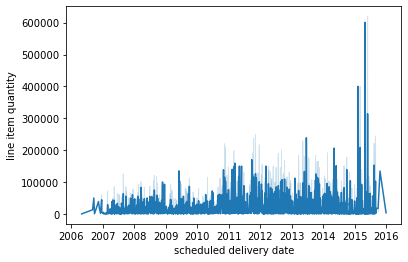

In [25]:
sns.lineplot(x="scheduled delivery date", y="line item quantity", data=df)

## Visualizations for 2015

In [26]:
df_year = df[df["scheduled delivery date"] >= "2015-01-01"]

<AxesSubplot:xlabel='scheduled delivery date', ylabel='line item quantity'>

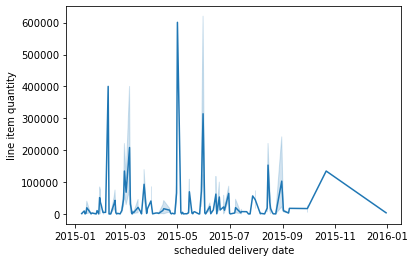

In [27]:
sns.lineplot(x="scheduled delivery date", y="line item quantity", data=df_year)

Above graph goes down nearing 2016 and that's where the supplying ends. It might be necessary to drop the second half of 2015 out of the model to avoid skewing the model. 

<AxesSubplot:xlabel='sub classification', ylabel='line item quantity'>

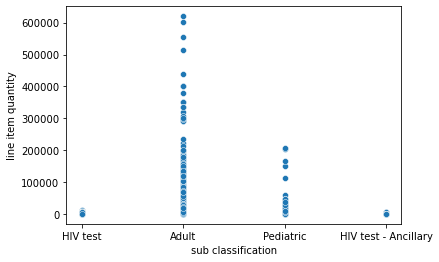

In [28]:
sns.scatterplot(data=df_year, x="sub classification", y="line item quantity")

## NEW TimeSeries Dataframe

In [38]:
ts_df = df.pivot_table(index='delivered to client date', columns='product group', values='line item quantity')
ts_df = ts_df.asfreq('MS', fill_value=0)
ts_df.index = pd.to_datetime(ts_df.index, format="%d-%m-%Y").strftime("%m-%Y") 
ts_df = ts_df.rename_axis("delivery date")
ts_df = ts_df.fillna(0)


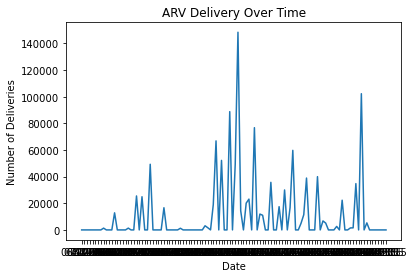

In [39]:
plt.plot(ts_df.index, ts_df['ARV'])

# titles and labels
plt.title('ARV Delivery Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Deliveries')


plt.show()

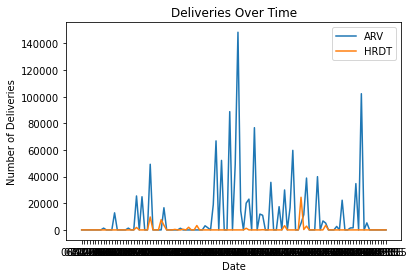

In [40]:
# the data
plt.plot(ts_df.index, ts_df['ARV'], label='ARV')
plt.plot(ts_df.index, ts_df['HRDT'], label='HRDT')

# titles and labels
plt.title('Deliveries Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Deliveries')

plt.legend()
plt.show()

In [41]:
ts_df.tail()

product group,ARV,HRDT
delivery date,,
05-2015,0.0,0.0
06-2015,0.0,0.0
07-2015,0.0,0.0
08-2015,0.0,0.0
09-2015,0.0,0.0


# Stationarity Test

In [53]:
dftest = adfuller(ts_df['ARV'])
display(dftest)


(-4.138387607831141,
 0.0008363015112980281,
 2,
 109,
 {'1%': -3.49181775886872,
  '5%': -2.8884437992971588,
  '10%': -2.5811201893779985},
 2260.4289455621606)

P-value (the second output) is 0.0008 which is less than alpha, I can reject the null hypothesis --The data is stationary

# First Simple Model

In [54]:
# Train-test split
train_data = ts_df.loc[:'09-2014']
test_data = ts_df.loc['10-2014':]

# ARIMA model
model = sm.tsa.ARIMA(train_data['ARV'], order=(1, 1, 1), dates=train_data.index, freq='MS')
results = model.fit()

predictions = results.predict(start='11-2014', end='10-2015')

# the mean absolute error of the predictions
mae = pd.Series.abs(predictions - test_data['ARV']).mean()
print('Mean Absolute Error:', mae)

Mean Absolute Error: 12242.545596446924


C:\Users\beyza\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [55]:
plt.plot(test_data.index, test_data['ARV'], label='Actual')
plt.plot(predictions.index, predictions, label='Predicted')

plt.title('ARIMA Model Predictions')
plt.xlabel('Date')
plt.ylabel('ARV')
plt.legend()

plt.show()


TypeError: tzinfo argument must be None or of a tzinfo subclass, not type 'UnitData'